In [2]:
import sys, os, decimal, json
sys.path.append(os.path.realpath('..'))
import json, time
import pandas as pd
import random
import matplotlib.pyplot as plt
import glob

import matplotlib.pyplot as plt
import numpy as np
import PIL, json
import tensorflow as tf
import socket
import pathlib
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageOps

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

from sklearn.metrics import confusion_matrix

from TrainingPipelines.ImageClassifier.ModelBuilder import build_and_train

import seaborn as sns
import mplcyberpunk

plt.style.use("cyberpunk")
plt.rcParams['figure.facecolor'] = '#0d1117'
plt.rcParams['axes.facecolor'] = '#0d1117'
plt.rcParams['savefig.facecolor'] = '#0d1117'

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
def cal_iou(y_true, y_pred):
    x1 = max(y_true[0], y_pred[0])
    y1 = max(y_true[1], y_pred[1])
    x2 = min(y_true[2], y_pred[2])
    y2 = min(y_true[3], y_pred[3])
 
    intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
 
    true_area = (y_true[2] - y_true[0] + 1) * (y_true[3] - y_true[1] + 1)
    bbox_area = (y_pred[2] - y_pred[0] + 1) * (y_pred[3] - y_pred[1] + 1)
 
    iou = intersection_area / float(true_area + bbox_area - intersection_area)
    return iou

In [5]:
reduction = 10

img_width = int(1920/reduction)
img_height = int(1080/reduction)

In [6]:
image_names = []
path = pathlib.Path('O:\\source\\repos\\data_labeler\\training_data\\\inventory')
for data in glob.glob(f"{path}\*.png"):
    file = data.split('\\')[-1:][0]
    image_names.append(file)

In [7]:
random.shuffle(image_names)

In [8]:
image_data = {}
f = open(f"{path}\\boxes.json")
image_data_raw = json.load(f)
f.close()

for data in image_data_raw:
    image_data[data['image_name']] = data['bbox']
image_data[list(image_data.keys())[0]]

[783, 430, 1333, 725]

In [9]:
for key in image_data:
    if image_data[key][0] > image_data[key][2]:
        print(key)

In [10]:
train_names, val_names, test_names = np.split(image_names, [int(len(image_names)*0.8), int(len(image_names)*0.9)])

In [11]:
train_x = []
for image_name in tqdm(train_names):
    try:
        img = Image.open(f"{path}\\{image_name}")
        if reduction != 1:
            img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
        train_x.append(np.array(img))
    except:
        print(f"{path}\\{image_name}")
    
val_x = []
for image_name in tqdm(val_names):
    img = Image.open(f"{path}\\{image_name}")
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    val_x.append(np.array(img))
    
test_x = []
for image_name in tqdm(test_names):
    img = Image.open(f"{path}\\{image_name}")
    if reduction != 1:
        img = img.resize((img_width, img_height), resample=Image.Resampling.NEAREST)
    test_x.append(np.array(img))
    
train_x = np.array(train_x)
val_x = np.array(val_x)
test_x = np.array(test_x)

100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 39.91it/s]


In [12]:
train_x[0].shape

(108, 192, 3)

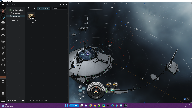

In [13]:
Image.fromarray(train_x[0])

In [14]:
train_y = []
for image_name in tqdm(train_names):
    train_y.append(image_data[image_name])
    
val_y = []
for image_name in tqdm(val_names):
    val_y.append(image_data[image_name])
    
test_y = []
for image_name in tqdm(test_names):
    test_y.append(image_data[image_name])

train_y = np.array(train_y) / np.array([1920, 1080, 1920, 1080])
val_y = np.array(val_y) / np.array([1920, 1080, 1920, 1080])
test_y = np.array(test_y) / np.array([1920, 1080, 1920, 1080])

100%|███████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 97007.03it/s]


In [15]:
train_names[0]

'a1eb2324-ccf0-11ed-b799-2cf05d9fe8eb.png'

In [16]:
train_y[0]

array([0.03020833, 0.02407407, 0.3578125 , 0.9537037 ])

In [17]:
model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    #layers.Normalization(input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.9),
    #layers.Dense(2048, activation='relu'),
    layers.Dense(4, activation="sigmoid")    
])

In [18]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 108, 192, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 106, 190, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 53, 95, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 51, 93, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 44, 64)        1

In [19]:
epochs = 100
lr = 1e-3

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=5, min_lr=1e-7, verbose=1),
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
]

IOUL = tfa.losses.GIoULoss(
    mode='giou',
    reduction=tf.keras.losses.Reduction.AUTO,
    name='giou_loss'
)


model.compile(optimizer=Adam(lr), loss='mse', metrics=['accuracy', 'mse', 'binary_crossentropy', 'BinaryIoU'])

history = model.fit(
    x=train_x,
    y=train_y,
    validation_data=(val_x, val_y),
    batch_size=32,
    #shuffle=True,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
25/25 [==============================] - 3s 21ms/step - loss: 0.0517 - accuracy: 0.4800 - mse: 0.0517 - binary_crossentropy: 0.6188 - binary_io_u: 0.2515 - val_loss: 0.0423 - val_accuracy: 0.4124 - val_mse: 0.0423 - val_binary_crossentropy: 0.5981 - val_binary_io_u: 0.2500 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0413 - accuracy: 0.6026 - mse: 0.0413 - binary_crossentropy: 0.5943 - binary_io_u: 0.2520 - val_loss: 0.0289 - val_accuracy: 0.7113 - val_mse: 0.0289 - val_binary_crossentropy: 0.5663 - val_binary_io_u: 0.2500 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0300 - accuracy: 0.7032 - mse: 0.0300 - binary_crossentropy: 0.5668 - binary_io_u: 0.2504 - val_loss: 0.0200 - val_accuracy: 0.7938 - val_mse: 0.0200 - val_binary_crossentropy: 0.5444 - val_binary_io_u: 0.2332 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 0s 8ms/step - loss: 0.0203 - accuracy: 0.7484 - mse:

In [20]:
def cell_dims(x1, y1, x2, y2):
    return x1, y1, (x2 - x1) + x1, (y2 - y1) + y1

In [21]:
prediction = model.predict(test_x)
IOUs = []
for i in range(len(test_y)):
    IOUs.append(cal_iou(prediction[i], test_y[i]))
print(f'Average IOU for Test:{sum(IOUs)/len(IOUs)}')

4/4 [==============================] - 0s 2ms/step
Average IOU for Test:0.9121381768174014


1/1 [==============================] - 0s 15ms/step
[[ 853.30839157  382.38772273 1534.40128326  769.47274446]]
[ 850.  359. 1521.  737.]
IOU:0.956449863220274
(853.3083915710449, 382.3877227306366, 1534.4012832641602, 769.4727444648743)


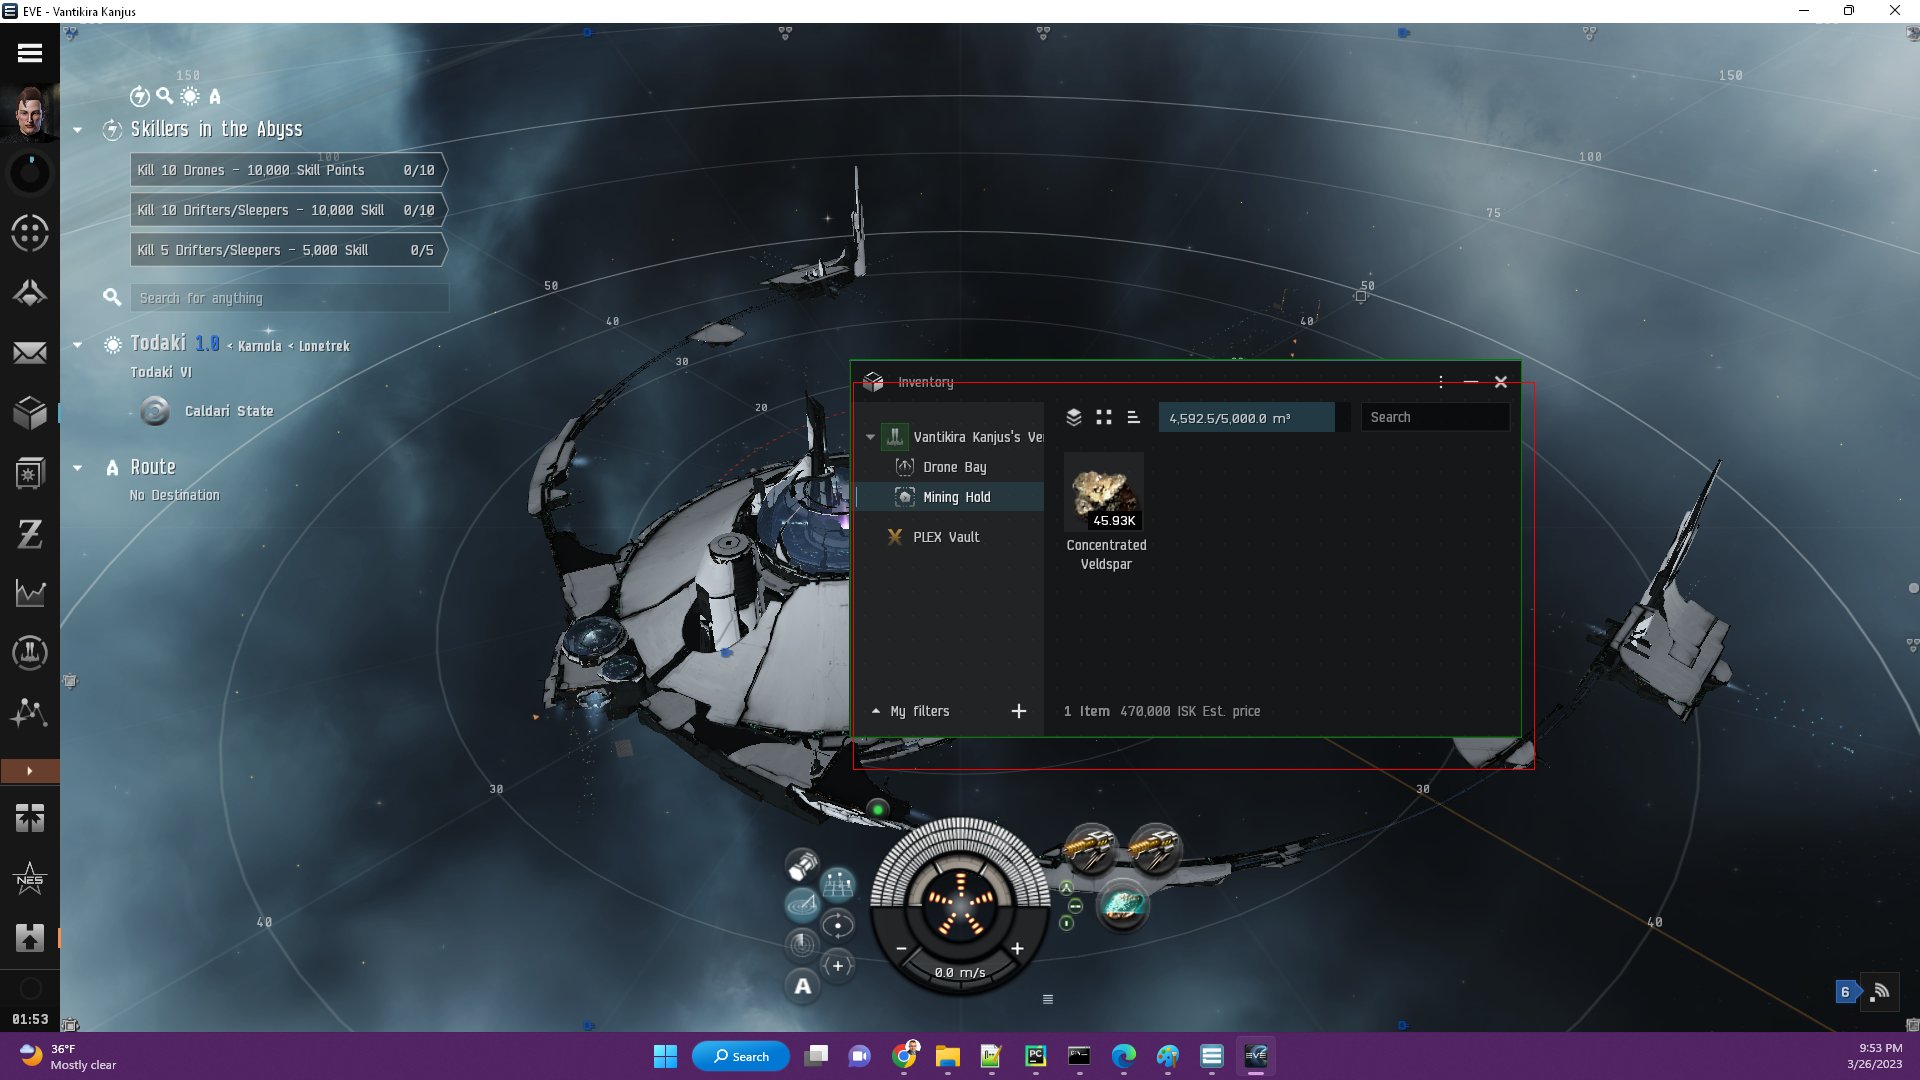

In [22]:
test_image_index = 6

prediction = model.predict(np.array([test_x[test_image_index]]))
result = ((prediction) * np.array([1920, 1080, 1920, 1080])) # reduction
print(result)
truth = (test_y[test_image_index] * np.array([1920, 1080, 1920, 1080])) # reduction
print(truth)

print(f'IOU:{cal_iou(prediction[0], test_y[test_image_index])}')

#mg = Image.fromarray(test_x[test_image_index]) 
img = Image.open(f"{path}\\{test_names[test_image_index]}")
img1 = ImageDraw.Draw(img)  
result2 = cell_dims(*result[0])
print(result2)
img1.rectangle([(result2[0], result2[1]), (result2[2], result2[3])], outline ="red")

result3 = cell_dims(*truth)
img1.rectangle([(result3[0], result3[1]), (result3[2], result3[3])], outline ="Green")


img

In [23]:
model.save('temp.h5')

In [24]:
model2 = tf.keras.models.load_model('temp.h5')
model2.predict(np.array([test_x[test_image_index]]))

1/1 [==============================] - 0s 46ms/step


array([[0.44443145, 0.3540627 , 0.79916734, 0.71247476]], dtype=float32)